In [1]:
import datetime
import json
import re
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
from nd2reader import ND2Reader

In [2]:
def split_acquisition_metadata_planes(l):
    # https://stackoverflow.com/questions/69832116/split-a-list-into-sublists-based-on-the-value-of-an-element
    x = [i for i, s in enumerate(l) if re.search("^Plane", s.lstrip())]
    y = x[1:] + [len(l)]
    z = [l[i:j] for i, j in zip(x, y)]
    return z


def parse_additional_metadata(acq_metadata):
    metadata_planes = split_acquisition_metadata_planes(
        acq_metadata["TextInfoItem_5"].split("\r\n")
    )
    metadata = ["\\n".join(plane) for plane in metadata_planes]
    metadata = [s.replace(",", ";") for s in metadata]
    return metadata


def get_start_time_abs(metadata_dict, common_metadata):
    start_time_abs = metadata_dict["date"]

    if start_time_abs is None:
        start_time_abs = common_metadata["TextInfoItem_9"]
        start_time_abs = datetime.datetime.strptime(
            start_time_abs, "%d/%m/%Y  %I:%M:%S %p"
        )
    return start_time_abs


def get_standard_field_id_mapping(df):
    image_metadata = df
    image_metadata = (
        image_metadata[["field_id", "stage_x_abs", "stage_y_abs"]]
        .groupby("field_id")
        .mean()
    )
    image_metadata[["stage_x_abs", "stage_y_abs"]] = image_metadata[
        ["stage_x_abs", "stage_y_abs"]
    ].round()
    image_metadata["XYCoordinates"] = image_metadata[
        ["stage_x_abs", "stage_y_abs"]
    ].apply(tuple, axis=1)
    image_metadata = image_metadata.reset_index()

    # Number fields from top-left to bottom-right (increase x first)
    unique_int_coords_sorted = sorted(
        list(set(image_metadata["XYCoordinates"])), key=lambda k: [k[1], k[0]]
    )
    coord_index = dict(
        zip(
            unique_int_coords_sorted,
            ["%0d" % i for i in range(1, len(unique_int_coords_sorted) + 1)],
        )
    )

    # keep this as StandardFieldID
    image_metadata["standard_field_id"] = image_metadata["XYCoordinates"].map(
        coord_index
    )
    return image_metadata[["field_id", "standard_field_id"]]


def extract_metadata_and_save(
    in_file_path: Union[str, Path], out_path: Union[str, Path]
):

    nd2_file = ND2Reader(in_file_path)
    acquisition_times = [t for t in nd2_file.parser._raw_metadata.acquisition_times]
    common_metadata = nd2_file.parser._raw_metadata.image_text_info[b"SLxImageTextInfo"]
    common_metadata = {
        key.decode(): val.decode() for key, val in common_metadata.items()
    }

    # save 'SLxImageTextInfo' as JSON
    json_file_path = Path(out_path) / Path(Path(in_file_path).stem + ".json")
    with open(json_file_path, "w") as outfile:
        json.dump(common_metadata, outfile)

    # parse metadata
    metadata_dict = nd2_file.parser._raw_metadata.__dict__
    additional_metadata = parse_additional_metadata(common_metadata)
    additional_metadata_df = pd.DataFrame(additional_metadata).T
    additional_metadata_df.columns = [
        "metadata_string_acquisition_" + str(i)
        for i in range(0, len(additional_metadata))
    ]

    # combine into dataframe
    metadata_df = pd.DataFrame(
        data={
            "n_pixels_y": metadata_dict["height"],
            "n_pixels_x": metadata_dict["width"],
            "objective_name": common_metadata["TextInfoItem_13"],
            "pixel_size_microns": metadata_dict["pixel_microns"],
            "stage_x_abs": nd2_file.parser._raw_metadata.x_data,
            "stage_y_abs": nd2_file.parser._raw_metadata.y_data,
            "stage_z_abs": nd2_file.parser._raw_metadata.z_data,
            "acquisition_time_rel": acquisition_times,
            "stage_z_id": list(metadata_dict["z_levels"])
            * (nd2_file.sizes["t"] * nd2_file.sizes["v"]),
            "field_id": list(
                np.repeat(range(1, 1 + nd2_file.sizes["v"]), nd2_file.sizes["z"])
            )
            * nd2_file.sizes["t"],
            "timepoint_id": list(
                np.repeat(
                    range(nd2_file.sizes["t"]),
                    nd2_file.sizes["z"] * nd2_file.sizes["v"],
                )
            ),
        }
    )

    metadata_df["filename_ome_tiff"] = [
        Path(in_file_path).stem + "_" + str(f).zfill(4) + ".ome.tiff"
        for f in metadata_df["field_id"]
    ]

    start_time_abs = get_start_time_abs(metadata_dict, common_metadata)
    if start_time_abs is not None:
        metadata_df["acquisition_time_abs"] = [
            start_time_abs + datetime.timedelta(seconds=x)
            for x in metadata_df["acquisition_time_rel"]
        ]

    # standardise field id (top-left to bottom-right)
    standard_field_id_mapping = get_standard_field_id_mapping(metadata_df)
    metadata_df = pd.merge(
        metadata_df, standard_field_id_mapping, on="field_id", how="left"
    )

    # add additional metadata as columns
    metadata_df = pd.merge(metadata_df, additional_metadata_df, how="cross")

    # write metadata to file
    with Path(out_path) / Path(
        Path(in_file_path).stem + "_metadata.csv"
    ) as out_file_path:
        metadata_df.to_csv(out_file_path, index=False)
    with Path(out_path) / Path(
        Path(in_file_path).stem + "_metadata.pkl"
    ) as out_file_path:
        metadata_df.to_pickle(out_file_path)

    return metadata_df

In [3]:
in_file_path = "/srv/scratch/berrylab/z3532965/Nikon_AX_QPI/20221010_BleachChase_POLR2A/20221010_144534_824/WellE05_ChannelGFP,AF647_Seq0001.nd2"
# in_file_path = '/srv/scratch/berrylab/z3536241/NikonNSTORM/221216/221212_Pbody_DDXImmuno/20221216_140317_611/Well01_ChannelAG_647_FISH,AG_568_FISH,AG_488NHS,AG_DAPI_Seq0000.nd2'
out_path = "/srv/scratch/berrylab/z3532965/Nikon_AX_QPI/"

In [4]:
tmp = extract_metadata_and_save(in_file_path, out_path)

In [5]:
from blimp.preprocessing import nd2_parse_metadata

tmp = nd2_parse_metadata.nd2_extract_metadata_and_save(
    in_file_path, out_path, mip=True, y_direction="down"
)

In [6]:
tmp

,n_pixels_y,n_pixels_x,objective_name,pixel_size_microns,field_id,timepoint_id,filename_ome_tiff,acquisition_time_rel,stage_y_abs,stage_x_abs,stage_z_n,acquisition_time_abs,standard_field_id,metadata_string_acquisition_0,metadata_string_acquisition_1
0,1024,1024,Plan Apo VC 20x DIC N2,0.428823,1,0,"WellE05_ChannelGFP,AF647_Seq0001_0001.ome.tiff",133.585174,3281.833333,12347.144444,9,2022-10-10 15:00:33.585174,1,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
1,1024,1024,Plan Apo VC 20x DIC N2,0.428823,2,0,"WellE05_ChannelGFP,AF647_Seq0001_0002.ome.tiff",141.514562,3285.533333,11907.900000,9,2022-10-10 15:00:41.514562,2,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
2,1024,1024,Plan Apo VC 20x DIC N2,0.428823,3,0,"WellE05_ChannelGFP,AF647_Seq0001_0003.ome.tiff",149.598083,3289.500000,11468.800000,9,2022-10-10 15:00:49.598083,3,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
3,1024,1024,Plan Apo VC 20x DIC N2,0.428823,4,0,"WellE05_ChannelGFP,AF647_Seq0001_0004.ome.tiff",157.399006,3293.300000,11029.500000,9,2022-10-10 15:00:57.399006,4,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
4,1024,1024,Plan Apo VC 20x DIC N2,0.428823,5,0,"WellE05_ChannelGFP,AF647_Seq0001_0005.ome.tiff",165.338793,3732.577778,11033.522222,9,2022-10-10 15:01:05.338793,8,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
5,1024,1024,Plan Apo VC 20x DIC N2,0.428823,6,0,"WellE05_ChannelGFP,AF647_Seq0001_0006.ome.tiff",173.426840,3728.788889,11473.100000,9,2022-10-10 15:01:13.426840,7,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
6,1024,1024,Plan Apo VC 20x DIC N2,0.428823,7,0,"WellE05_ChannelGFP,AF647_Seq0001_0007.ome.tiff",181.458264,3724.800000,11911.900000,9,2022-10-10 15:01:21.458264,6,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
7,1024,1024,Plan Apo VC 20x DIC N2,0.428823,8,0,"WellE05_ChannelGFP,AF647_Seq0001_0008.ome.tiff",189.343981,3720.700000,12351.100000,9,2022-10-10 15:01:29.343981,5,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
8,1024,1024,Plan Apo VC 20x DIC N2,0.428823,9,0,"WellE05_ChannelGFP,AF647_Seq0001_0009.ome.tiff",197.158972,4159.955556,12354.822222,9,2022-10-10 15:01:37.158972,9,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...
9,1024,1024,Plan Apo VC 20x DIC N2,0.428823,10,0,"WellE05_ChannelGFP,AF647_Seq0001_0010.ome.tiff",204.953519,4163.800000,11915.600000,9,2022-10-10 15:01:44.953519,10,Plane #1:\n Name: GFP\n Component Count: 1\n M...,Plane #2:\n Name: AF647\n Component Count: 1\n...


In [7]:
from pathlib import Path

# Check stitching using standard field ids
from aicsimageio import AICSImage

mip_path = Path(in_file_path).parent / "OME-TIFF-MIP"

05-Jan-23 13:13:10 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [8]:
# print mapping
tmp2 = (
    tmp[["field_id", "stage_x_abs", "stage_y_abs", "standard_field_id"]]
    .groupby(["field_id", "standard_field_id"])
    .mean()
)
tmp2[["stage_x_abs", "stage_y_abs"]] = tmp2[["stage_x_abs", "stage_y_abs"]].round()
tmp2[["stage_y_abs", "stage_x_abs"]].drop_duplicates()

,,stage_y_abs,stage_x_abs
field_id,standard_field_id,,
1,1,3282.0,12347.0
2,2,3286.0,11908.0
3,3,3290.0,11468.0
4,4,3294.0,11029.0
5,8,3733.0,11033.0
6,7,3729.0,11473.0
7,6,3725.0,11912.0
8,5,3721.0,12351.0
9,9,4160.0,12355.0


In [9]:
import os

image_files = os.listdir(mip_path)
image_files.sort()

In [10]:
images = [AICSImage(mip_path / f) for f in image_files]
standard_field_id_mapping = tmp[["field_id", "standard_field_id"]].drop_duplicates()
field_id_to_standard_field_id = standard_field_id_mapping.set_index(
    "field_id"
).T.to_dict("index")["standard_field_id"]
field_id_to_standard_field_id

/srv/scratch/z3532965/anaconda3/envs/berrylab-default/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


{1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '8',
 6: '7',
 7: '6',
 8: '5',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '16',
 14: '15',
 15: '14',
 16: '13'}

In [11]:
new_order = [int(s) for s in field_id_to_standard_field_id.values()]
images_reorder = [images[i - 1] for i in new_order]
stitched_array = np.vstack(
    [
        np.hstack(
            [
                images_reorder[i + 4 * j].get_image_data("YX", T=0, C=0)
                for i in range(0, 4)
            ]
        )
        for j in range(0, 4)
    ]
)

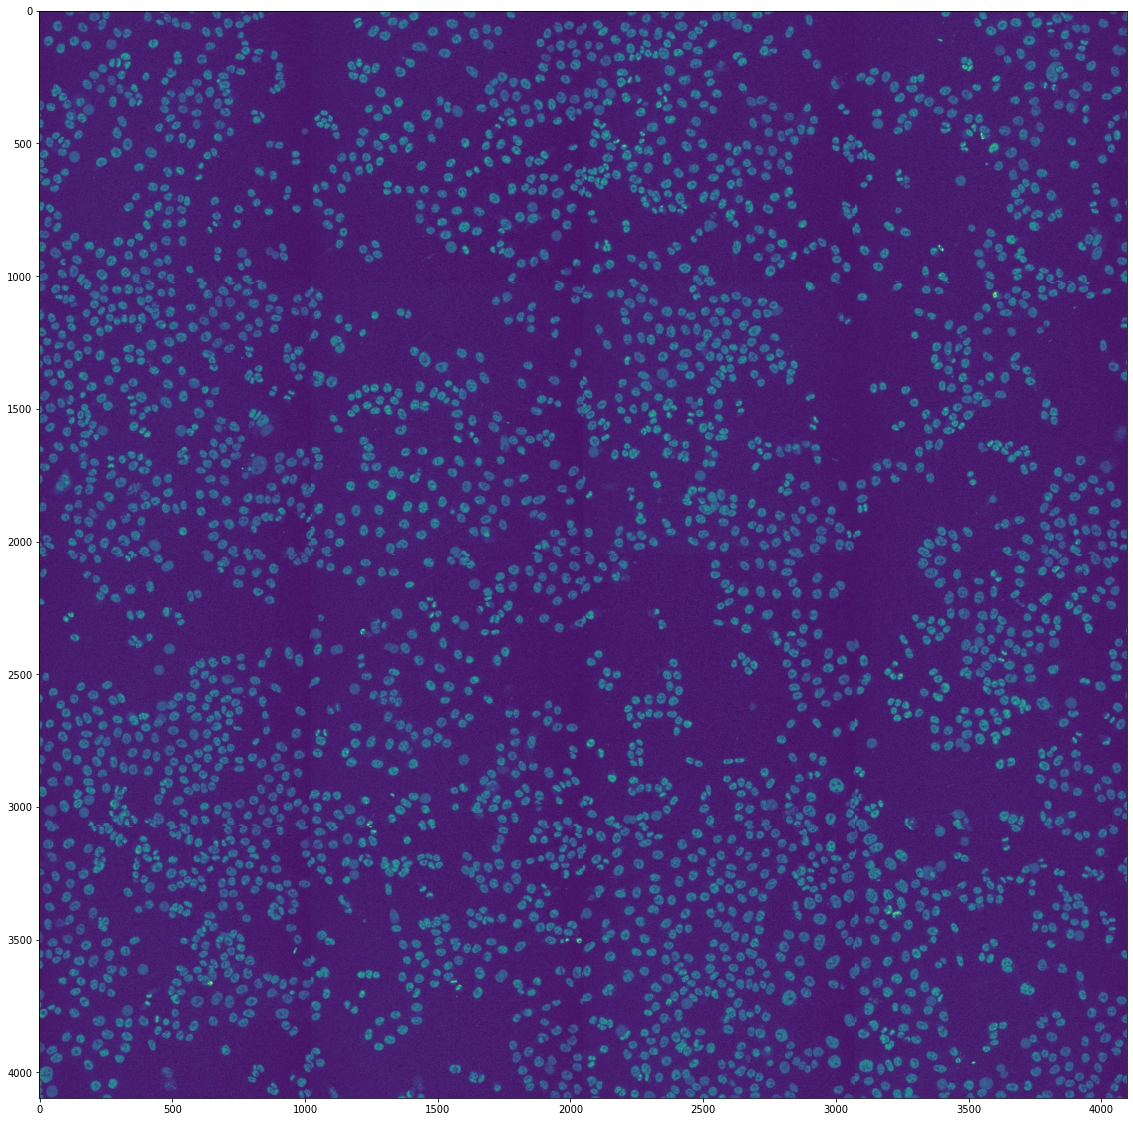

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
plt.imshow(stitched_array)
plt.show()